HIV/AIDS outbreak was one of the most impactful events of the last 30 years and still it is one of the leading causes of death especially in Africa. Today I'll be trying to find correlations between some other factors through 10 year periods and try to find an explanation to why Africa is especially impacted by the crisis.

In [9]:
#SQL Connection and required libraries
from mysql.connector import errorcode
import matplotlib.pyplot as plt
import mysql.connector
import pandas as pd
import warnings
import numpy as np
import matplotlib.ticker as ticker

warnings.filterwarnings("ignore")
def connectionCreator():
    try:
        cnx = mysql.connector.connect(
            user = "root", password = "cs306zort", database = "cs_306"
        )
        print("Connection established with the database")
        return cnx
    except mysql.connector.Error as err: 
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with your username or your password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
        return None
    else:
        cnx.close()
        return None


cnx = connectionCreator()

Connection established with the database


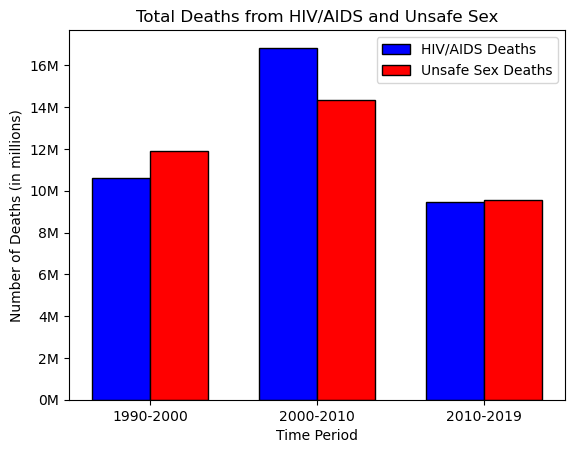

In [10]:
query = """
    SELECT 
        SUM(CASE WHEN continent_code <> 'REG' THEN deaths_by_hiv_aids ELSE 0 END) AS hiv_deaths,
        SUM(CASE WHEN continent_code <> 'REG' THEN deaths_by_unsafe_sex ELSE 0 END) AS unsafe_sex_deaths,
        CASE
            WHEN year BETWEEN 1990 AND 2000 THEN '1990-2000'
            WHEN year BETWEEN 2000 AND 2010 THEN '2000-2010'
            WHEN year BETWEEN 2010 AND 2019 THEN '2010-2019'
        END AS time_period
    FROM health_deaths AS hd
    JOIN locatedin AS li ON hd.iso_code = li.iso_code
    WHERE li.continent_code <> 'REG'
    GROUP BY time_period
"""


df = pd.read_sql(query, cnx)

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(df))
r2 = [x + bar_width for x in r1]

plt.bar(r1, df['hiv_deaths'], color='blue', width=bar_width, edgecolor='black', label='HIV/AIDS Deaths')
plt.bar(r2, df['unsafe_sex_deaths'], color='red', width=bar_width, edgecolor='black', label='Unsafe Sex Deaths')

# Add x-axis ticks and labels
plt.xticks([r + bar_width/2 for r in r1], df['time_period'])

plt.xlabel('Time Period')
plt.ylabel('Number of Deaths (in millions)')  # Updated y-axis label
plt.title('Total Deaths from HIV/AIDS and Unsafe Sex')
plt.legend()

# Scale y-axis to millions
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}M'.format(x * 1e-6)))

plt.show()

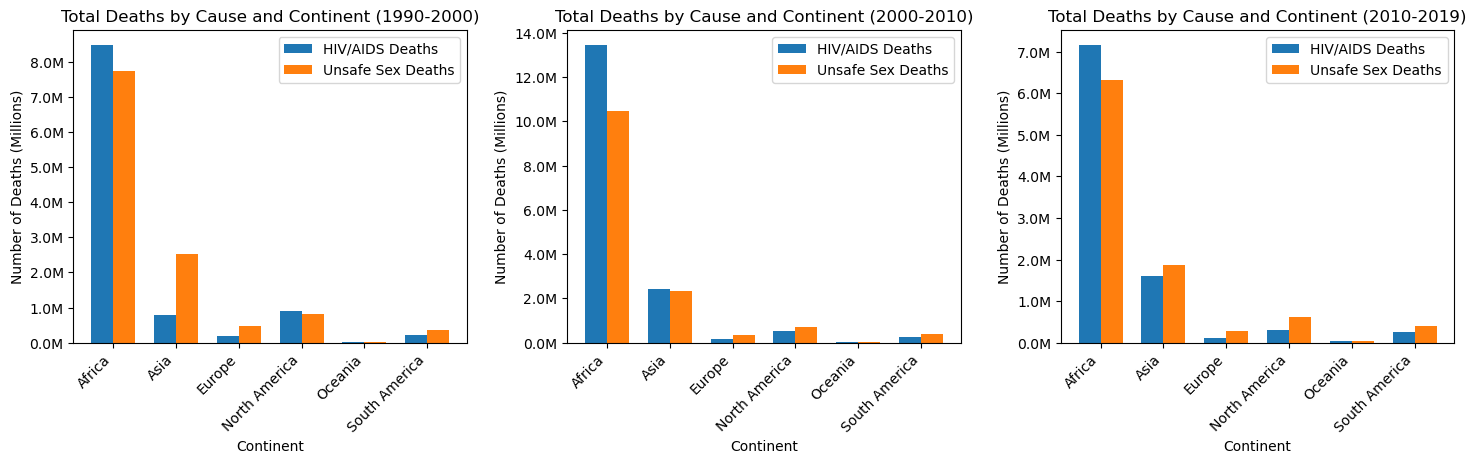

In [15]:
# Define the time periods
time_periods = ['1990-2000', '2000-2010', '2010-2019']

# Create subplots for each time period
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the data for each time period
for i, period in enumerate(time_periods):
    # Query the data for the specific time period
    query = f"""
        SELECT 
            SUM(CASE WHEN li.continent_code <> 'REG' THEN hd.deaths_by_hiv_aids ELSE 0 END) AS hiv_deaths,
            SUM(CASE WHEN li.continent_code <> 'REG' THEN hd.deaths_by_unsafe_sex ELSE 0 END) AS unsafe_sex_deaths,
            c.name
        FROM health_deaths AS hd
        JOIN locatedin AS li ON hd.iso_code = li.iso_code
        JOIN continents AS c ON li.continent_code = c.continent_code
        WHERE li.continent_code <> 'REG' AND
              (CASE
                  WHEN hd.year BETWEEN 1990 AND 2000 THEN '1990-2000'
                  WHEN hd.year BETWEEN 2000 AND 2010 THEN '2000-2010'
                  WHEN hd.year BETWEEN 2010 AND 2019 THEN '2010-2019'
              END) = '{period}'
        GROUP BY c.name
    """

    df = pd.read_sql(query, cnx)

    # Scale y-axis to millions
    df['hiv_deaths'] /= 1e6
    df['unsafe_sex_deaths'] /= 1e6

    # Plot the data as a double bar graph on the corresponding subplot
    ax = axs[i]
    bar_width = 0.35
    index = np.arange(len(df))

    ax.bar(index, df['hiv_deaths'], bar_width, label='HIV/AIDS Deaths')
    ax.bar(index + bar_width, df['unsafe_sex_deaths'], bar_width, label='Unsafe Sex Deaths')

    ax.set_xlabel('Continent')
    ax.set_ylabel('Number of Deaths (Millions)')  # Updated y-axis label
    ax.set_title(f'Total Deaths by Cause and Continent ({period})')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(df['name'], rotation=45, ha='right')

    # Format y-axis values to millions
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.1f}M'))

    ax.legend()

plt.tight_layout(pad=2)
plt.show()




As can be cleary seen, Africa is by far the most affected continent. Now let's try to find correlations.

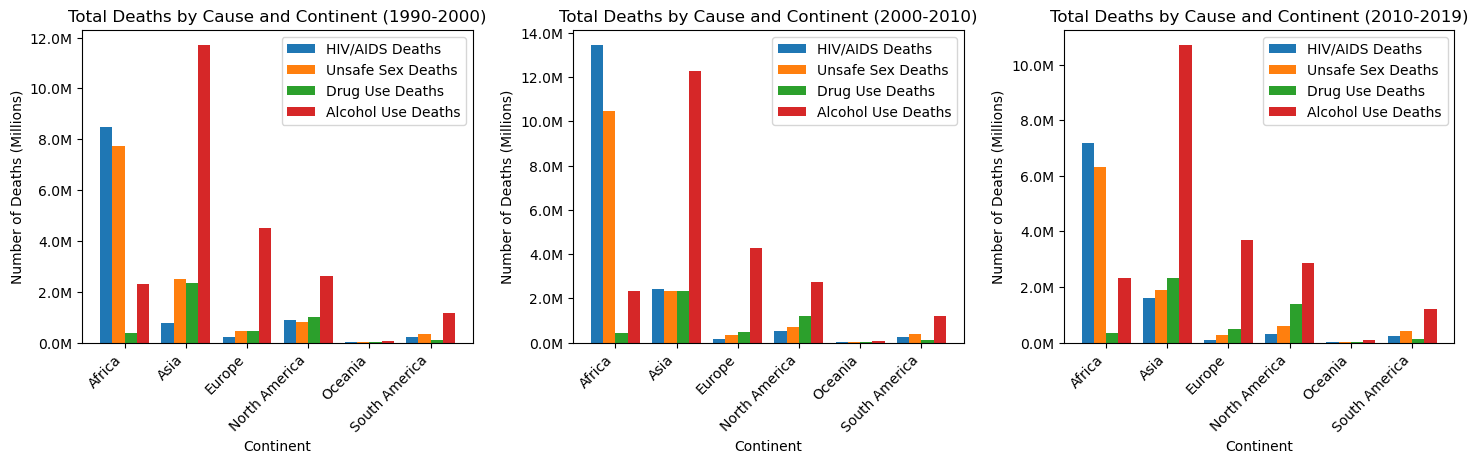

In [11]:
# Define the time periods
time_periods = ['1990-2000', '2000-2010', '2010-2019']

# Create subplots for each time period
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the data for each time period
for i, period in enumerate(time_periods):
    # Query the data for the specific time period
    query = f"""
        SELECT 
            SUM(CASE WHEN li.continent_code <> 'REG' THEN hd.deaths_by_hiv_aids ELSE 0 END) AS hiv_deaths,
            SUM(CASE WHEN li.continent_code <> 'REG' THEN hd.deaths_by_unsafe_sex ELSE 0 END) AS unsafe_sex_deaths,
            SUM(CASE WHEN li.continent_code <> 'REG' THEN sd.deaths_by_drug_use ELSE 0 END) AS drug_use_deaths,
            SUM(CASE WHEN li.continent_code <> 'REG' THEN sd.deaths_by_alcohol_use ELSE 0 END) AS alcohol_use_deaths,
            c.name
        FROM health_deaths AS hd
        JOIN locatedin AS li ON hd.iso_code = li.iso_code
        JOIN continents AS c ON li.continent_code = c.continent_code
        JOIN substance_deaths AS sd ON hd.iso_code = sd.iso_code AND hd.year = sd.year
        WHERE li.continent_code <> 'REG' AND
              (CASE
                  WHEN hd.year BETWEEN 1990 AND 2000 THEN '1990-2000'
                  WHEN hd.year BETWEEN 2000 AND 2010 THEN '2000-2010'
                  WHEN hd.year BETWEEN 2010 AND 2019 THEN '2010-2019'
              END) = '{period}'
        GROUP BY c.name
    """

    df = pd.read_sql(query, cnx)

    # Scale y-axis to millions
    df['hiv_deaths'] /= 1e6
    df['unsafe_sex_deaths'] /= 1e6
    df['drug_use_deaths'] /= 1e6
    df['alcohol_use_deaths'] /= 1e6

    # Plot the data as a quadruple bar graph on the corresponding subplot
    ax = axs[i]
    bar_width = 0.2
    index = np.arange(len(df))

    ax.bar(index, df['hiv_deaths'], bar_width, label='HIV/AIDS Deaths')
    ax.bar(index + bar_width, df['unsafe_sex_deaths'], bar_width, label='Unsafe Sex Deaths')
    ax.bar(index + 2 * bar_width, df['drug_use_deaths'], bar_width, label='Drug Use Deaths')
    ax.bar(index + 3 * bar_width, df['alcohol_use_deaths'], bar_width, label='Alcohol Use Deaths')

    ax.set_xlabel('Continent')
    ax.set_ylabel('Number of Deaths (Millions)')
    ax.set_title(f'Total Deaths by Cause and Continent ({period})')
    ax.set_xticks(index + 1.5 * bar_width)
    ax.set_xticklabels(df['name'], rotation=45, ha='right')

    # Format y-axis values to millions
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.1f}M'))

    ax.legend()

plt.tight_layout(pad=2)
plt.show()


No correlation is observed with drug and alcohol use related deaths.


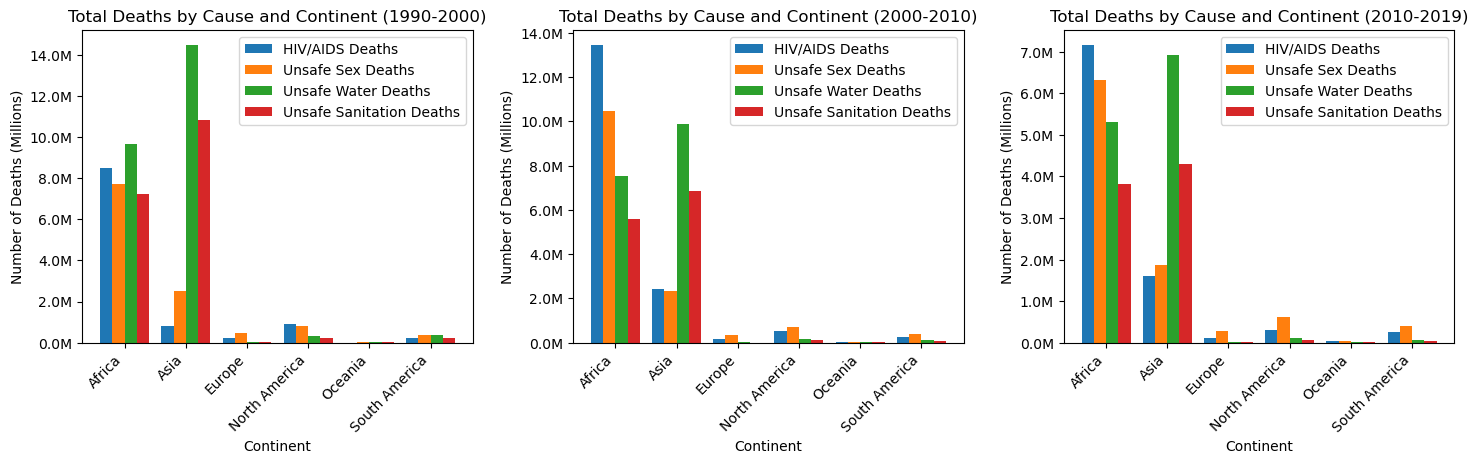

In [17]:
# Create subplots for each time period
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the data for each time period
for i, period in enumerate(time_periods):
    # Query the data for the specific time period
    query = f"""
        SELECT 
            SUM(CASE WHEN li.continent_code <> 'REG' THEN hd.deaths_by_hiv_aids ELSE 0 END) AS hiv_deaths,
            SUM(CASE WHEN li.continent_code <> 'REG' THEN hd.deaths_by_unsafe_sex ELSE 0 END) AS unsafe_sex_deaths,
            SUM(CASE WHEN li.continent_code <> 'REG' THEN nd.deaths_by_unsafe_water_source ELSE 0 END) AS unsafe_water_deaths,
            SUM(CASE WHEN li.continent_code <> 'REG' THEN nd.deaths_by_unsafe_sanitation ELSE 0 END) AS unsafe_sanitation_deaths,
            c.name
        FROM health_deaths AS hd
        JOIN locatedin AS li ON hd.iso_code = li.iso_code
        JOIN continents AS c ON li.continent_code = c.continent_code
        JOIN nature_deaths AS nd ON hd.iso_code = nd.iso_code AND hd.year = nd.year
        WHERE li.continent_code <> 'REG' AND
              (CASE
                  WHEN hd.year BETWEEN 1990 AND 2000 THEN '1990-2000'
                  WHEN hd.year BETWEEN 2000 AND 2010 THEN '2000-2010'
                  WHEN hd.year BETWEEN 2010 AND 2019 THEN '2010-2019'
              END) = '{period}'
        GROUP BY c.name
    """

    df = pd.read_sql(query, cnx)

    # Scale y-axis to millions
    df['hiv_deaths'] /= 1e6
    df['unsafe_sex_deaths'] /= 1e6
    df['unsafe_water_deaths'] /= 1e6
    df['unsafe_sanitation_deaths'] /= 1e6

    # Plot the data as a quadruple bar graph on the corresponding subplot
    ax = axs[i]
    bar_width = 0.2
    index = np.arange(len(df))

    ax.bar(index, df['hiv_deaths'], bar_width, label='HIV/AIDS Deaths')
    ax.bar(index + bar_width, df['unsafe_sex_deaths'], bar_width, label='Unsafe Sex Deaths')
    ax.bar(index + 2 * bar_width, df['unsafe_water_deaths'], bar_width, label='Unsafe Water Deaths')
    ax.bar(index + 3 * bar_width, df['unsafe_sanitation_deaths'], bar_width, label='Unsafe Sanitation Deaths')

    ax.set_xlabel('Continent')
    ax.set_ylabel('Number of Deaths (Millions)')
    ax.set_title(f'Total Deaths by Cause and Continent ({period})')
    ax.set_xticks(index + 1.5 * bar_width)
    ax.set_xticklabels(df['name'], rotation=45, ha='right')

    # Format y-axis values to millions
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.1f}M'))

    ax.legend()

plt.tight_layout(pad=2)
plt.show()

cnx.close()

Even though some correlation can be observed in African data, the data from Asia creates an inconsistency thus we can't really show a correlation with these data either.

After further testing and more inconsistent results, I couldn't find any correlating factors in our dataset so It's safe to say that further research should be done on genetic and cultural data from the region.
